In [1]:
#Imports
from matplotlib import rcParams 
from matplotlib import pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
#Import local Data

alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load('/LinuxSata/Dokumente/Master of Neuroscience/NMA_CN_2021/steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
    
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [3]:
def compute_accuracy(X, y, model):
    """Compute accuracy of classifier predictions.

    Args:
        X (2D array): Data matrix
        y (1D array): Label vector
        model (sklearn estimator): Classifier with trained weights.

    Returns:
        accuracy (float): Proportion of correct predictions.
    """

    y_pred = model.predict(X)
 

    accuracy = np.sum(y_pred == y) / len(y)

    return accuracy

In [4]:
def model_selection(X, y, C_values, k_fold, penalty='l2'):
    """Compute CV accuracy for each C value.
    Args:
        X (2D array): Data matrix
        y (1D array): Label vector
        C_values (1D array): Array of hyperparameter values.
    Returns:
        accuracies (1D array): CV accuracy with each value of C.
    """
    accuracies = []
    for C in C_values:

        # Initialize and fit the model
        # (Hint, you may need to set max_iter)
        model = LogisticRegression(penalty=penalty, C=C, max_iter=5000, solver='liblinear')

        # Get the accuracy for each test split using cross-validation
        accs = cross_val_score(model, X, y, cv=k_fold)

        # Store the average test accuracy for this value of C
        accuracies.append(accs.mean())

    return accuracies


def plot_model_selection(C_values, accuracies):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, accuracies, marker="o")
    best_C = C_values[np.argmax(accuracies)]
    ax.set(
        xticks=C_values,
        xlabel="$C$",
        ylabel="Cross-validated accuracy",
        title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
        )

def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(10, 2.5 * n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)

    for ax, (title, model) in zip(axs, models.items()):

        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=3)
        ax.set(ylabel="Weight", title=title)
        ax.set(xlabel="Neuron (a.k.a. feature)")
        f.tight_layout()
    
    
# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

In [5]:
# Some Filters: 
dat = alldat[11]
start_idx = ((dat['gocue'] * 1/dat['bin_size']).astype(int)).squeeze() # from go cue time get the index of the first bin 
stop_idx = ((dat['response_time'] * 1/dat['bin_size']).astype(int)).squeeze() # from the response time get the index of the last bin

# only from cue on:
after_cue = np.zeros_like(dat['spks'][0, :, :], dtype = bool)
before_response = np.zeros_like(dat['spks'][0, :, :], dtype = bool)

for i, j in enumerate(start_idx):
    after_cue[i, j:] = True

for i, j in enumerate(stop_idx):
    before_response[i, :j] = True
    
between_cue_and_response = after_cue & before_response


spike_times = np.where(dat['spks'][0] == 1)

    
#plt.eventplot(spike_times)
        #avg_hz.append(dat['spks'][:, i, j].mean(axis = 1))
        #response.append(dat['response'][i])
        

In [6]:
avg_hz = []
response = []

for i,j in enumerate(between_cue_and_response):    
    if j.sum() >= 25 and dat['response'][i] != 0 :
        avg_hz.append(dat['spks'][:, i, j].mean(axis = 1))
        response.append(dat['response'][i])
        
avg_hz = np.asarray(avg_hz)
print(avg_hz.shape)



(82, 698)


In [7]:
#Split up into different brain regions:
nareas = 7 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"

for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = int(j) # assign a number to each region
    


Visual Cortex
Thalamus
Hippocampal
Non-Visual Cortex


[Text(1, 0, 'Visual Cortex'),
 Text(2, 0, 'Thalamus'),
 Text(3, 0, 'Hippocampal'),
 Text(4, 0, 'Non-Visual Cortex')]

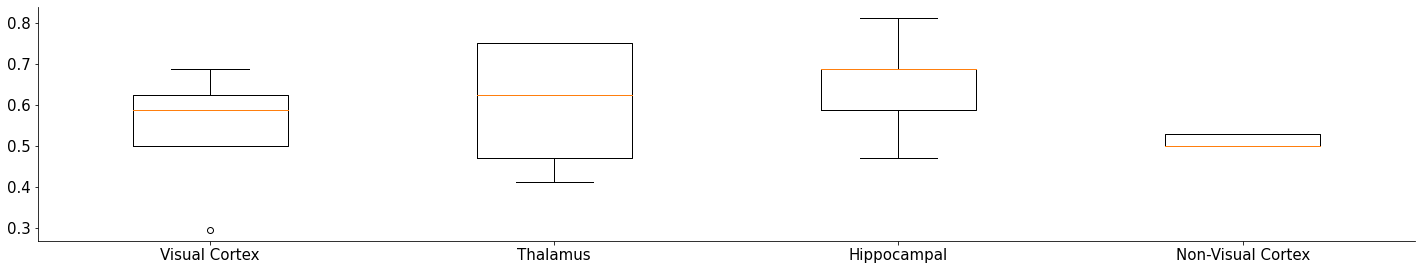

In [16]:
pooled_areas = ["Visual Cortex","Thalamus","Hippocampal","Non-Visual Cortex", "Midbrain","Basal Gangilia", "Cortical Subplate"]

results = dict.fromkeys(pooled_areas)

log_reg = LogisticRegression(penalty="l2")
k_fold = 16

models = dict.fromkeys(pooled_areas)


for j in range(7):
    if avg_hz[:, barea==j].shape[-1] > 0:     
        
        print(pooled_areas[j])
        models[pooled_areas[j]] = BaggingClassifier(
            base_estimator=LogisticRegression(
                penalty="l1",  max_iter=5000, solver='liblinear'), n_estimators=10, random_state=0).fit(avg_hz[:, barea==j], response)
        
        accuracies = cross_val_score(BaggingClassifier(base_estimator=LogisticRegression(penalty="l1",  max_iter=5000, solver='liblinear'), n_estimators=10, random_state=0),
                                    avg_hz[:, barea==j], response)
        
        results[pooled_areas[j]] = accuracies


del results['Midbrain']
del results['Basal Gangilia']
del results['Cortical Subplate']

fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())



In [73]:

for i, j in enumerate(pooled_areas):
    
    if models[j]:
        print(models[j].score(avg_hz[:, barea==i], response))

0.6707317073170732
0.7073170731707317
0.6585365853658537
0.5121951219512195


In [ ]:
#Loop over all Experiments:
pooled_areas = ["Visual Cortex","Thalamus","Hippocampal","Non-Visual Cortex", "Midbrain","Basal Gangilia", "Cortical Subplate"]

results = []

counter = 0

k_fold = 8

for dat in alldat:
    
    print('experiment ', counter)
    counter += 1
    
    
    
    area = dict.fromkeys(pooled_areas)

    for i in pooled_areas:
        area[i] = []

    
    start_idx = ((dat['gocue'] * 1/dat['bin_size']).astype(int)).squeeze() 
    stop_idx = ((dat['response_time'] * 1/dat['bin_size']).astype(int)).squeeze() 
    
    # only from cue on:
    after_cue = np.zeros_like(dat['spks'][0, :, :], dtype = bool)
    before_response = np.zeros_like(dat['spks'][0, :, :], dtype = bool)

    for i, j in enumerate(start_idx):
        after_cue[i, j:] = True

    for i, j in enumerate(stop_idx):
        before_response[i, :j] = True
    
    between_cue_and_response = after_cue & before_response
    
    avg_hz = []
    response = []

    for i,j in enumerate(between_cue_and_response):    
        if j.sum() >= 50 and dat['response'][i] != 0 :
            avg_hz.append(dat['spks'][:, i, j].mean(axis = 1))
            response.append(dat['response'][i])
        
    avg_hz = np.asarray(avg_hz)

    #Split up into different brain regions:
    nareas = 7 # only the top 4 regions are in this particular mouse
    NN = len(dat['brain_area']) # number of neurons
    barea = nareas * np.ones(NN, ) 
    
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = int(j) # assign a number to each region
    

    for j in range(7):
        
        
        print(pooled_areas[j])
        
        if avg_hz[:, barea==j].shape[-1] > 0:             
            
            area[pooled_areas[j]] = BaggingClassifier(base_estimator=LogisticRegression(
                                                                        penalty="l1",
                                                                        max_iter=5000,
                                                                        solver='liblinear'),
                
                                    n_estimators=10,
                                    random_state=0).fit(avg_hz[:, barea==j], response)
            
            print(area[pooled_areas[j]].score(avg_hz[:, barea==j], response))
            
            print(avg_hz[:, barea==j])
            
    results.append(area)
               
            
            
            
            
            
            

# Is using avg_hz the right way? 

# Use the whole time window until the response - turns out this performse worse

# Using maybe only very clear trials? - high contrast trials

#spikes: an array of normalized spike rates .... how to do that? 

In [18]:
# for experiment in results:
#     for i, j in enumerate(pooled_areas):
#         if experiment[j]:
#             print(experiment[j].score(avg_hz[:, barea==i], response))

for experiment in results:
    for i, j in enumerate(pooled_areas):
        if len(experiment[j]) > 0:
            print(experiment[j].score(avg_hz[:, barea==i], response))
            


ValueError: Number of features of the model must match the input. Model n_features is 178 and input n_features is 141.

Text(0.5, 0, 'experiment')

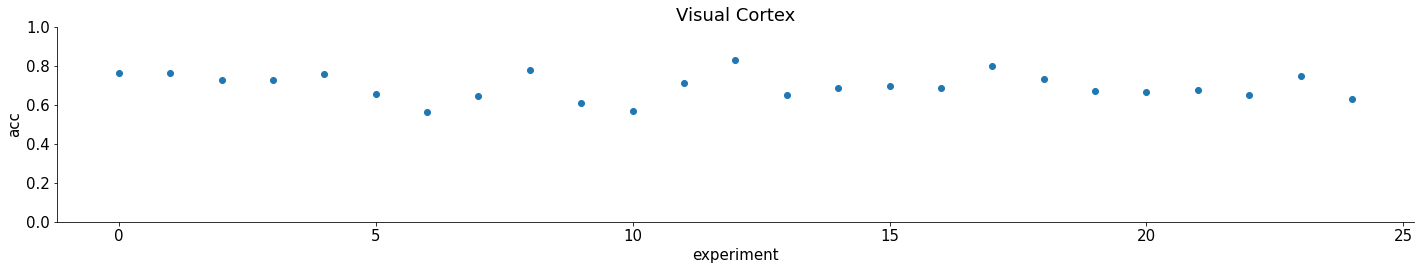

In [36]:
plt.scatter(range(len(results['Visual Cortex'])) ,results['Visual Cortex'])
plt.ylim(0, 1)
plt.title('Visual Cortex')
plt.ylabel('acc')
plt.xlabel('experiment')

Text(0.5, 0, 'experiment')

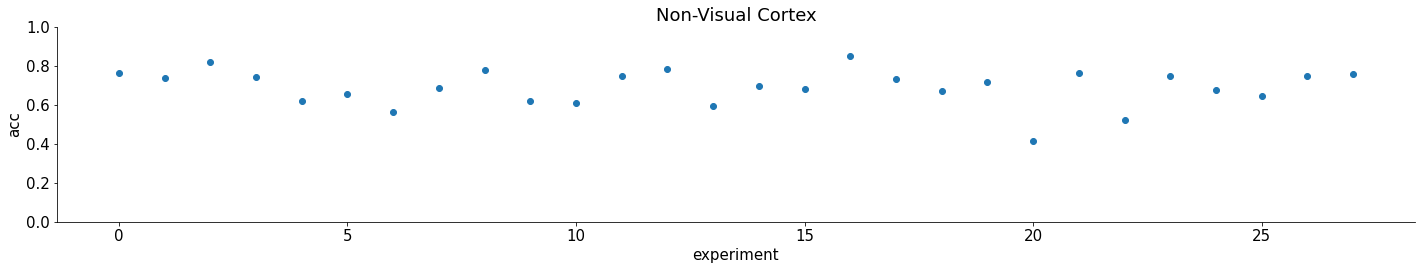

In [37]:
plt.scatter(range(len(results['Non-Visual Cortex'])) ,results['Non-Visual Cortex'])
plt.ylim(0, 1)
plt.title('Non-Visual Cortex')
plt.ylabel('acc')
plt.xlabel('experiment')

[Text(1, 0, 'Visual Cortex'),
 Text(2, 0, 'Thalamus'),
 Text(3, 0, 'Hippocampal'),
 Text(4, 0, 'Non-Visual Cortex'),
 Text(5, 0, 'Midbrain'),
 Text(6, 0, 'Basal Gangilia'),
 Text(7, 0, 'Cortical Subplate')]

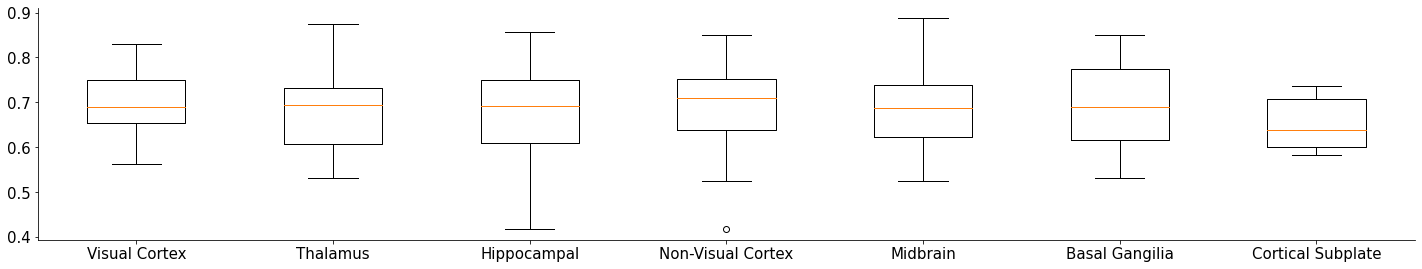

In [38]:
fig, ax = plt.subplots()
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

In [74]:
dat.keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

In [ ]:
plot_weights(model)